In [4]:
from obspy import UTCDateTime


In [5]:
import pandas as pd
from obspy import UTCDateTime

# Path to your file
file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial.csv"
file_path_new = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_new.csv"

# Read the CSV
df = pd.read_csv(file_path)

# Conversion function
def convert_to_utc(date_str, sec):
    year = int(date_str[:2])
    year += 1900 if year >= 70 else 2000
    month = int(date_str[2:4])
    day = int(date_str[4:6])
    hour = int(date_str[6:8])
    minute = int(date_str[8:10])
    second = float(sec)
    return UTCDateTime(year, month, day, hour, minute, second).isoformat()

# Add new column
df["starttime"] = df.apply(lambda row: convert_to_utc(str(row["Date_hour_min"]), row["Seconds"]), axis=1)

# Overwrite the same file (or change path to save as new)
df.to_csv(file_path_new, index=False)

print(f"CSV updated with 'starttime' column at {file_path_new}")


CSV updated with 'starttime' column at /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_new.csv


In [ ]:
lat_15 = 26.13174
lon_15 = 3.63803

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


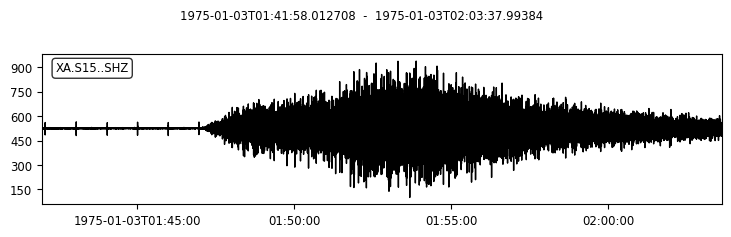

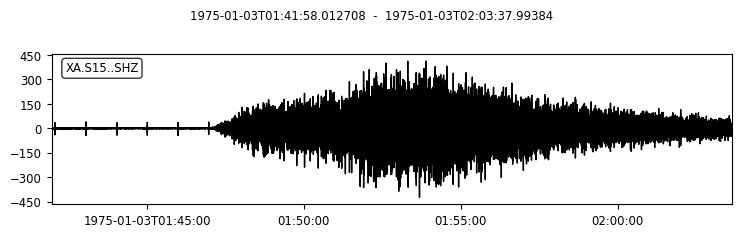

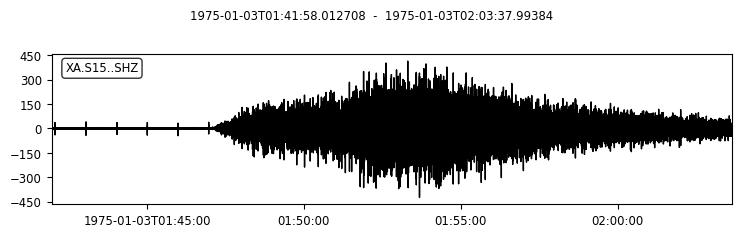

Sampling rate: 53.0 Hz


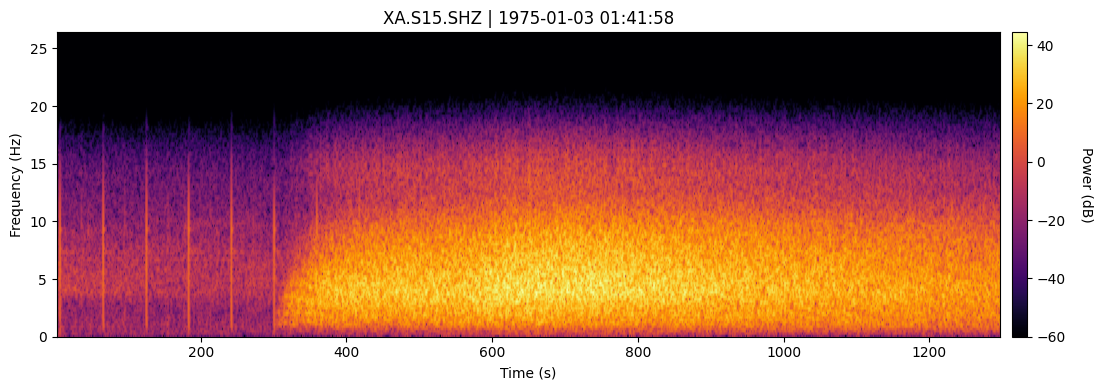

In [23]:
from heterogeneities.io import view_apollo, plot_spectrogram_title, get_Apollo
from heterogeneities.processing import preprocess_trace, compute_spectrogram
from obspy import UTCDateTime

trace = get_Apollo(
        starttime=UTCDateTime("1975-01-03T01:41:58"),
        endtime=UTCDateTime("1975-01-03T01:41:58") + 1300,
        station="S15",
        channel="SHZ",

    )   


st= trace[0].copy()
st.plot()
preprocessed_trace = preprocess_trace(st)
preprocessed_trace.plot()
preprocessed_trace.filter("bandpass", freqmin=0.1, freqmax=15, corners=4, zerophase=True)

preprocessed_trace.plot()
dB, extent, freqs, times = compute_spectrogram(preprocessed_trace, window_sec=5, db_limits=None)
plot_spectrogram_title(dB, extent, preprocessed_trace, vmin=-60, vmax=None, show = False)



In [143]:
R_moon = 1737.4
import numpy as np
df_time = pd.read_csv(file_path_new)

def latlon_depth_to_cartesian(lat, lon, depth):
    """
    Convert latitude (deg), longitude (deg), and depth (km below surface)
    into Cartesian coordinates centered at lunar center.
    """
    r = R_moon - depth
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    x = r * np.cos(lat_rad) * np.cos(lon_rad)
    y = r * np.cos(lat_rad) * np.sin(lon_rad)
    z = r * np.sin(lat_rad)
    return np.array([x, y, z])

# Apollo 15 seismometer coordinates (lat, lon, depth=0)
apollo15_lat = 26.132
apollo15_lon = 3.633
apollo15_depth = 0.0
apollo15_xyz = latlon_depth_to_cartesian(apollo15_lat, apollo15_lon, apollo15_depth)

apollo14_lat = -3.645
apollo14_lon = 342.552
apollo14_depth = 0.0
apollo14_xyz = latlon_depth_to_cartesian(apollo14_lat, apollo14_lon, apollo14_depth)

apollo16_lat = -8.976
apollo16_lon = 15.499
apollo16_depth = 0.0
apollo16_xyz = latlon_depth_to_cartesian(apollo16_lat, apollo16_lon, apollo16_depth)

# Compute hypocentral distances
df_time["hypo_dist_A14_km"] = df_time.apply(
    lambda row: np.linalg.norm(latlon_depth_to_cartesian(row["Lat"], row["Long"], row["Depth"]) - apollo14_xyz),
    axis=1
)
# Compute hypocentral distances
df_time["hypo_dist_A15_km"] = df_time.apply(
    lambda row: np.linalg.norm(latlon_depth_to_cartesian(row["Lat"], row["Long"], row["Depth"]) - apollo15_xyz),
    axis=1
)

df_time["hypo_dist_A16_km"] = df_time.apply(
    lambda row: np.linalg.norm(latlon_depth_to_cartesian(row["Lat"], row["Long"], row["Depth"]) - apollo16_xyz),
    axis=1
)

print(df_time[["Type", "Lat", "Long", "Depth", "hypo_dist_A14_km"]])
print(df_time[["Type", "Lat", "Long", "Depth", "hypo_dist_A15_km"]])
print(df_time[["Type", "Lat", "Long", "Depth", "hypo_dist_A16_km"]])

# Save updated file if needed
out_path = file_path.replace(".csv", "_with_dist.csv")
df_time.to_csv(out_path, index=False)
print(f"Updated CSV saved at: {out_path}")

  Type   Lat  Long  Depth  hypo_dist_A14_km
0   SH  48.0  38.2     10       2006.064996
1   SH  21.9  82.6      2       2673.455821
2   SH  26.1 -92.7      0       2197.412038
3   SH  64.1  59.9      0       2409.555374
4   SH -17.0 -26.1     21        475.919546
5   SH  44.1  34.0    125       1834.067257
6   SH  52.5 -25.8    185       1567.847422
  Type   Lat  Long  Depth  hypo_dist_A15_km
0   SH  48.0  38.2     10       1033.713725
1   SH  21.9  82.6      2       2019.467831
2   SH  26.1 -92.7      0       2324.698122
3   SH  64.1  59.9      0       1526.593559
4   SH -17.0 -26.1     21       1512.021300
5   SH  44.1  34.0    125        885.695444
6   SH  52.5 -25.8    185        987.908211
  Type   Lat  Long  Depth  hypo_dist_A16_km
0   SH  48.0  38.2     10       1743.149099
1   SH  21.9  82.6      2       2056.863977
2   SH  26.1 -92.7      0       2850.263247
3   SH  64.1  59.9      0       2241.305019
4   SH -17.0 -26.1     21       1216.386140
5   SH  44.1  34.0    125       

In [5]:
import pandas as pd

def read_lognonne_table(filepath: str) -> pd.DataFrame:
  
    try:
        df = pd.read_csv(filepath)
        return df
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

# Example usage:
file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_with_dist.csv"
df = read_lognonne_table(file_path)

if df is not None:
    print(df.head())   # show first 5 rows
    print(df.columns)  # list all column names


Error reading file: [Errno 2] No such file or directory: '/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_with_dist.csv'


In [140]:
from heterogeneities.processing import linear_interpolation, preprocess_trace, compute_spectrogram
import importlib
import heterogeneities.io
importlib.reload(heterogeneities.io)
import matplotlib.pyplot as plt
from heterogeneities.io import view_apollo, plot_spectrogram_title
from pathlib import Path

base_dir = Path("/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_SH_Lognonne")


for row in df.itertuples():
    trace = view_apollo(
        stream=None,
        starttime=UTCDateTime(row.starttime),
        endtime=UTCDateTime(row.starttime)+1300,
        network="XA",
        station="S15",
        channel="SHZ",
        location="*",
        plot_seismogram=False,
        plot_response=False,
    )
    tr = trace[0].copy()
    _ = linear_interpolation(tr)
    tr_processed = preprocess_trace(tr)
    # ---- build per-entry subfolder + filename stem
    stamp = tr.stats.starttime.strftime("%Y%m%dT%H%M%S")
    stem  = f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}_{stamp}"
    out_dir = base_dir / stem
    out_dir.mkdir(parents=True, exist_ok=True)


    times = np.arange(len(tr_processed.data)) * tr_processed.stats.delta
    plt.style.use("default")   # reset to default (white background)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(times, tr_processed.data * 1e9, linewidth=0.5, color="red")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Velocity (nm/s)")
    # Define hypocentral distance (assuming it's stored in the row)
    hypo_dist = getattr(row, "hypo_dist_A15_km", None)

    # Title
    title = (
        f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel} | "
        f"{tr.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
    )
    if hypo_dist is not None:
        title += f" | {hypo_dist:.1f} km"
    ax.set_title(title)
    ax.set_facecolor("white") 
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    seismo_path = out_dir / f"{stem}_seismogram.pdf"
    fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
    plt.close(fig)  # 

    #print("Antes:", tr.data.mean(), tr.data.min(), tr.data.max())
    #print("Después:", tr_processed.data.mean(), tr_processed.data.min(), tr_processed.data.max())

    dB, extent, freqs, times = compute_spectrogram(tr_processed, window_sec=0.8, db_limits=None)
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A15_km)
    spec_path = out_dir / f"{stem}_spectrogram.pdf"
    plt.savefig(spec_path, dpi=300, bbox_inches="tight")
    plt.close()  

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


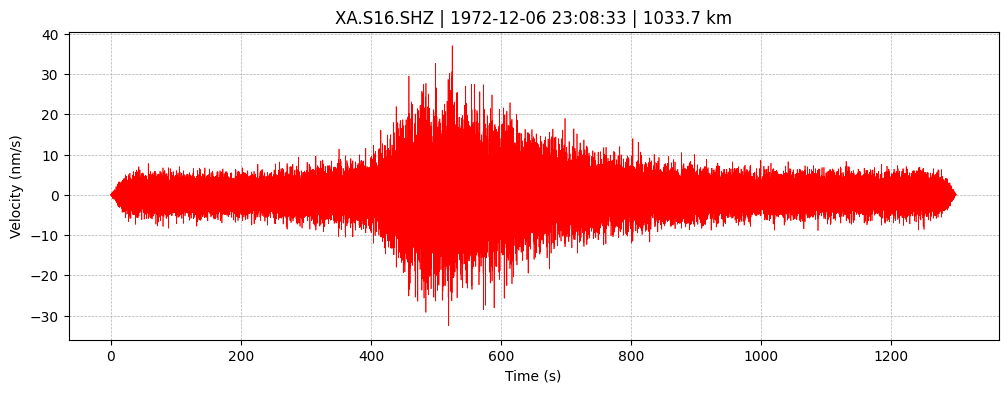

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


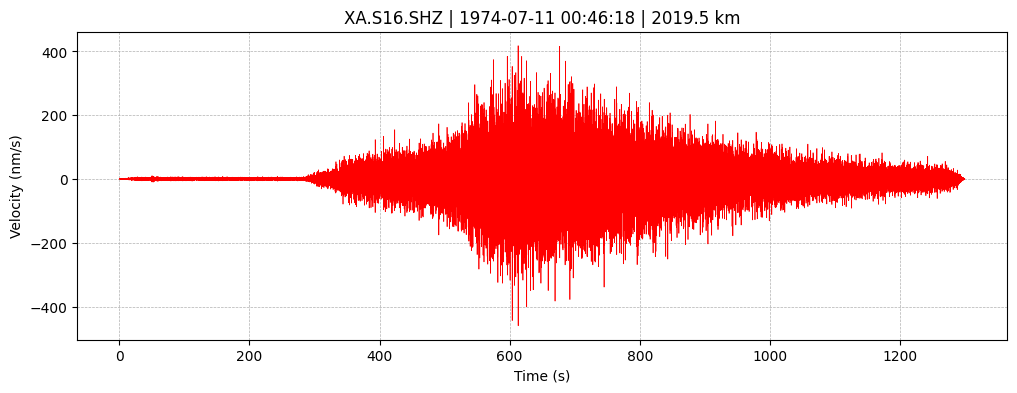

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


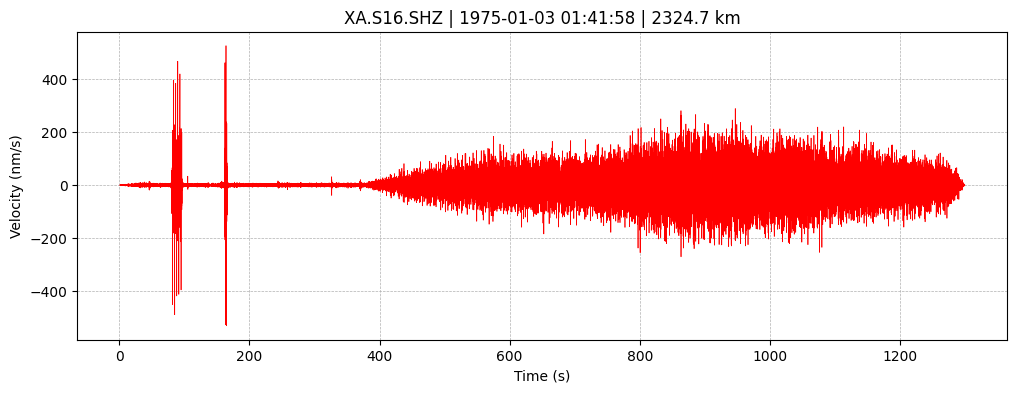

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


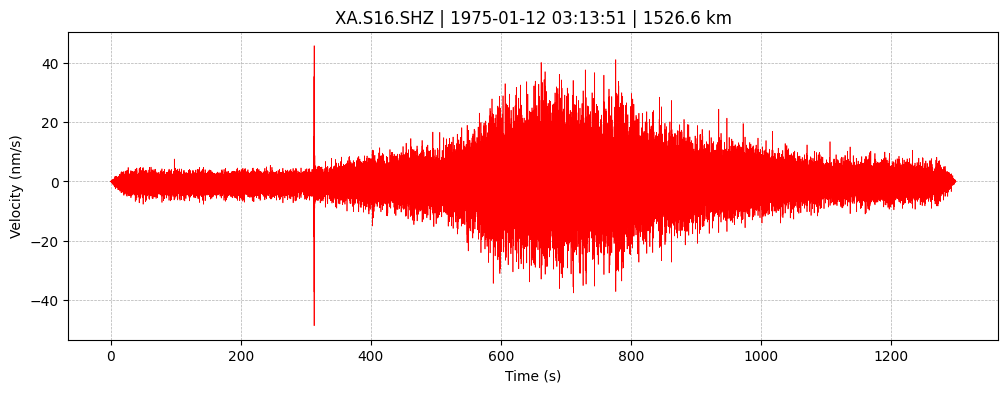

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


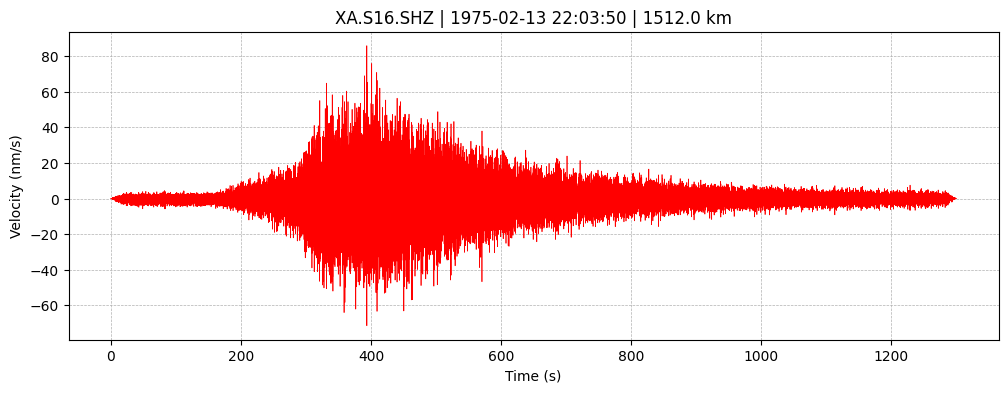

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


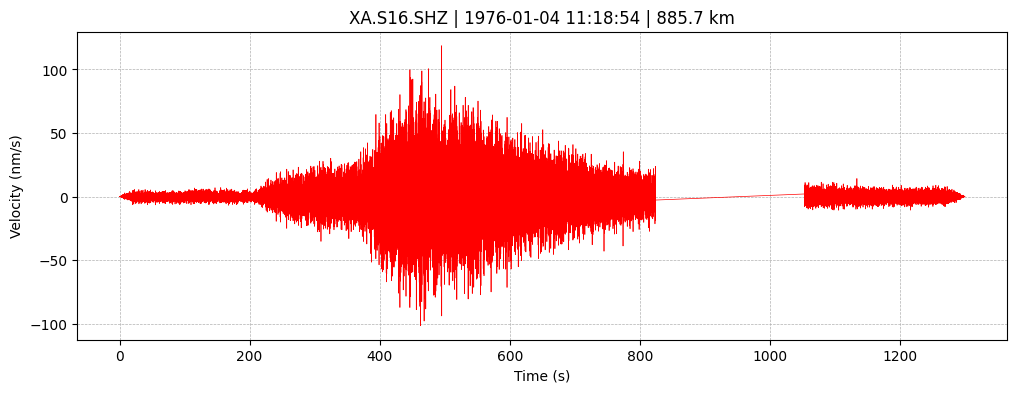

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


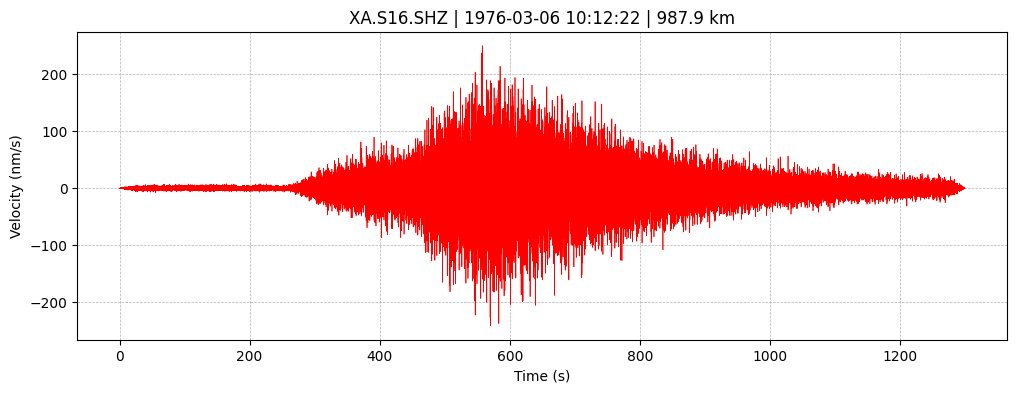

In [159]:
file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_with_dist_with_dist.csv"
df = read_lognonne_table(file_path)
for row in df.itertuples():
    trace = view_apollo(
        stream=None,
        starttime=UTCDateTime(row.starttime),
        endtime=UTCDateTime(row.starttime)+1300,
        network="XA",
        station="S16",#can be S14 S15 or S16
        channel="SHZ",
        location="*",
        plot_seismogram=False,
        plot_response=False,
    )
    tr = trace[0].copy()
    _ = linear_interpolation(tr)
    tr_processed = preprocess_trace(tr)
  

    times = np.arange(len(tr_processed.data)) * tr_processed.stats.delta
    plt.style.use("default")   # reset to default (white background)
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(times, tr_processed.data * 1e9, linewidth=0.5, color="red")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Velocity (nm/s)")
    # Here we have to better write the code to read the correct distance conlumn
    hypo_dist = getattr(row, "hypo_dist_A14_km", None)
    hypo_dist = getattr(row, "hypo_dist_A15_km", None)
    hypo_dist = getattr(row, "hypo_dist_A16_km", None)

    # Title
    title = (
        f"{tr.stats.network}.{tr.stats.station}.{tr.stats.channel} | "
        f"{tr.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
    )
    if hypo_dist is not None:
        title += f" | {hypo_dist:.1f} km"
    ax.set_title(title)
    ax.set_facecolor("white") 
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    seismo_path = out_dir / f"{stem}_seismogram.pdf"
    fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    dB, extent, freqs, times = compute_spectrogram(tr_processed, window_sec=0.8, db_limits=None)
    #here agian we have to addapt the code to better read the correct distance column, not amanually just loop idk
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A14_km)
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A15_km)
    ax = plot_spectrogram_title(dB, extent, tr_processed, vmin=-190, vmax=-150, show=False, hypo_dist=row.hypo_dist_A16_km)
    spec_path = out_dir / f"{stem}_spectrogram.pdf"
    plt.savefig(spec_path, dpi=300, bbox_inches="tight")
    plt.close()  

In [232]:
importlib.reload(heterogeneities.processing)
import importlib
import heterogeneities.io
importlib.reload(heterogeneities.io)


<module 'heterogeneities.processing' from '/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py'>

In [6]:
import importlib
import heterogeneities.io
import heterogeneities.processing

importlib.reload(heterogeneities.io)
importlib.reload(heterogeneities.processing)

import matplotlib.pyplot as plt
from heterogeneities.io import view_apollo, plot_spectrogram_title
from pathlib import Path

from heterogeneities.processing import _latlon_depth_to_cartesian_vec, compute_and_save_hypo_distances
file_path_new = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Lognonne_M_with_starttime.csv"
df_deep = pd.read_csv(file_path_new)

df_deep, out_path = compute_and_save_hypo_distances(
    df_deep,
    file_path_new,
    R_moon_km=1737.4,
    stations=None,
    out_suffix="_with_dist.csv"
)


In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime

# Station mapping between seismogram station codes (S14...) and Apollo codes (A14...)
STATION_TO_APOLLO = {"S14": "A14", "S15": "A15", "S16": "A16"}

def _safe_hypo_distance(row, station):
    """Pick the correct hypo distance column for this station, or return None."""
    apollo = STATION_TO_APOLLO.get(station)
    if not apollo:
        return None
    col = f"hypo_dist_{apollo}_km"
    return getattr(row, col, None)

def _event_folder_name(tr, apollo_code):
    """Folder name: XA.A*.SHZ_YYYYMMDDThhmmss"""
    t0 = tr.stats.starttime
    timestamp = t0.strftime("%Y%m%dT%H%M%S")
    return f"XA.{apollo_code}.SHZ_{timestamp}"

def batch_make_plots(
    file_path,
    out_root="plots",
    stations=("S14", "S15", "S16"),
    network="XA",
    channel="SHZ",
    location="*",
    duration_sec=1300,
    spectrogram_kwargs=None,
):
    """
    For each row in the CSV, fetch seismograms for the requested stations and
    save a seismogram + spectrogram PDF in per-station folders:

      {out_root}/A14/XA.A14.SHZ_YYYYMMDDThhmmss/{seismogram,spectrogram}.pdf
    """
    spectrogram_kwargs = spectrogram_kwargs or {}
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)

    df = read_lognonne_table(file_path)

    for row in df.itertuples():
        try:
            start = UTCDateTime(getattr(row, "starttime"))
            end = start + duration_sec
        except Exception as e:
            print(f"[SKIP] Row {getattr(row, 'Index', '?')}: invalid starttime ({e})")
            continue

        for station in stations:
            apollo_code = STATION_TO_APOLLO[station]
            try:
                # Fetch waveform
                st = view_apollo(
                    stream=None,
                    starttime=start,
                    endtime=end,
                    network=network,
                    station=station,
                    channel=channel,
                    location=location,
                    plot_seismogram=False,
                    plot_response=False,
                )

                if not st or len(st) == 0:
                    print(f"[SKIP] {station} {start}: no data returned")
                    continue

                tr = st[0].copy()
                _ = linear_interpolation(tr)
                trp = preprocess_trace(tr)

                # Build station folder: out_root / A14 / XA.A14.SHZ_YYYYMMDDThhmmss
                station_dir = out_root / apollo_code / _event_folder_name(trp, apollo_code)
                station_dir.mkdir(parents=True, exist_ok=True)

                # ---------- Seismogram ----------
                times = np.arange(len(trp.data)) * trp.stats.delta
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(times, trp.data * 1e9, linewidth=0.5, color="red")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Velocity (nm/s)")

                # Title with hypo distance
                hypo_dist = _safe_hypo_distance(row, station)
                title = (
                    f"{trp.stats.network}.{apollo_code}.{trp.stats.channel} | "
                    f"{trp.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
                )
                if hypo_dist is not None:
                    title += f" | {hypo_dist:.1f} km"
                ax.set_title(title)
                ax.grid(True, linestyle="--", linewidth=0.5)

                seismo_path = station_dir / "seismogram.pdf"
                fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
                plt.close(fig)

                # ---------- Spectrogram ----------
                dB, extent, freqs, stimes = compute_spectrogram(
                    trp,
                    window_sec=spectrogram_kwargs.get("window_sec", 0.8),
                    db_limits=spectrogram_kwargs.get("db_limits", None),
                )

                ax = plot_spectrogram_title(
                    dB,
                    extent,
                    trp,
                    vmin=spectrogram_kwargs.get("vmin", -190),
                    vmax=spectrogram_kwargs.get("vmax", -150),
                    show=False,
                    hypo_dist=hypo_dist,
                )
                spec_path = station_dir / "spectrogram.pdf"
                plt.savefig(spec_path, dpi=300, bbox_inches="tight")
                plt.close()

                print(f"[OK] {apollo_code} {start} → {station_dir}")

            except Exception as e:
                print(f"[ERROR] {station} {start}: {e}")
                continue


file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Lognonne_M_with_dist.csv"

batch_make_plots(
    file_path=file_path,
    out_root="/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Trash/First_Results_M_Lognonne",
    stations=("S14", "S15", "S16"),   # or e.g. ("S16",) if you only want S16
    duration_sec=1300,
    spectrogram_kwargs={"window_sec": 0.8, "vmin": -260, "vmax": -180}
)


NameError: name 'read_lognonne_table' is not defined

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


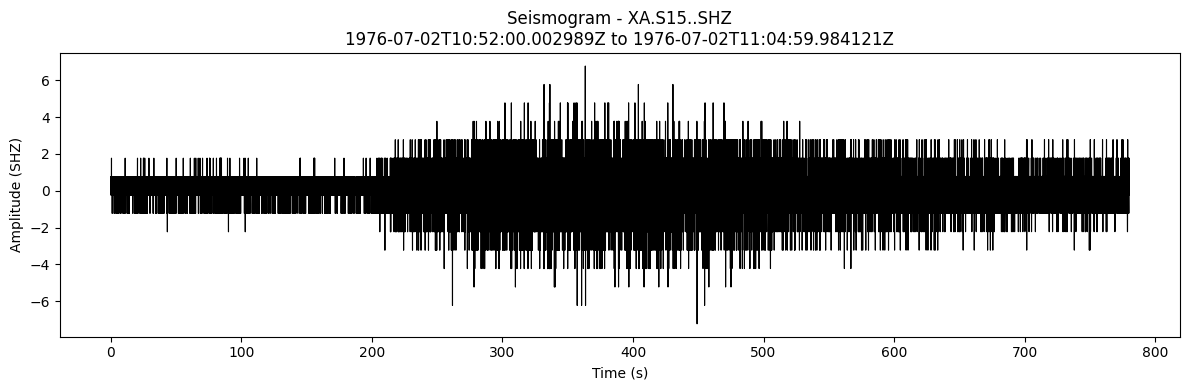

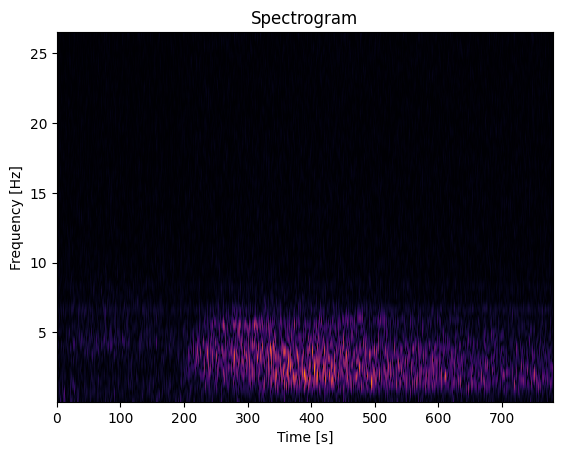

In [ ]:
from obspy import UTCDateTime
from heterogeneities.io import view_apollo, plot_spectrogram_title, get_Apollo
from heterogeneities.processing import preprocess_trace, compute_spectrogram, linear_interpolation
import matplotlib.pyplot as plt
# stream = get_Apollo(
#      starttime=UTCDateTime("1976-07-02T10:52:00"),
#     endtime=UTCDateTime("1976-07-02T11:05:00") ,
#     station="S15",
#         channel="SHZ",

#     )
trace = get_Apollo(
    starttime=UTCDateTime("1976-07-02T10:52:00"),
    endtime=UTCDateTime("1976-07-02T11:05:00"), 
    station="S15", channel="SHZ", 
    units="VEL", year=None, month=None)

trace_pre = trace.copy()
_ = linear_interpolation(trace_pre)
tr_processed = preprocess_trace(trace_pre)

# ---- plot ----
plt.figure(figsize=(12, 4))
plt.plot(tr_processed.times(), tr_processed.data, color="black", linewidth=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude ({})".format(tr_processed.stats.channel))
plt.title(f"Seismogram - {tr_processed.id}\n{tr_processed.stats.starttime} to {tr_processed.stats.endtime}")

plt.tight_layout()
plt.show()

tr_processed.spectrogram(log=False, title="Spectrogram", cmap="inferno", wlen=2)

In [17]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import pandas as pd
from heterogeneities.io import view_apollo, plot_spectrogram_title, get_Apollo
from heterogeneities.processing import linear_interpolation, preprocess_trace, compute_spectrogram
# Station mapping between seismogram station codes (S14...) and Apollo codes (A14...)
STATION_TO_APOLLO = {"S14": "A14", "S15": "A15", "S16": "A16"}

def _safe_hypo_distance(row, station):
    """Pick the correct hypo distance column for this station, or return None."""
    apollo = STATION_TO_APOLLO.get(station)
    if not apollo:
        return None
    col = f"hypo_dist_{apollo}_km"
    return getattr(row, col, None)

def _event_folder_name(tr, apollo_code):
    """Folder name: XA.A*.SHZ_YYYYMMDDThhmmss"""
    t0 = tr.stats.starttime
    timestamp = t0.strftime("%Y%m%dT%H%M%S")
    return f"XA.{apollo_code}.SHZ_{timestamp}"


def read_lognonne_table(filepath):
  
    try:
        df = pd.read_csv(filepath)
        return df
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

def batch_make_plots(
    file_path,
    out_root="plots",
    stations=("S14", "S15", "S16"),
    network="XA",
    channel="SHZ",
    location="*",
    duration_sec=1300,
    spectrogram_kwargs=None,
):
    """
    For each row in the CSV, fetch seismograms for the requested stations and
    save a seismogram + spectrogram PDF in per-station folders:

      {out_root}/A14/XA.A14.SHZ_YYYYMMDDThhmmss/{seismogram,spectrogram}.pdf
    """
    spectrogram_kwargs = spectrogram_kwargs or {}
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)
    
    df = read_lognonne_table(file_path)

    for row in df.itertuples():
        try:
            start = UTCDateTime(getattr(row, "starttime"))
            end = start + duration_sec
        except Exception as e:
            print(f"[SKIP] Row {getattr(row, 'Index', '?')}: invalid starttime ({e})")
            continue

        for station in stations:
            apollo_code = STATION_TO_APOLLO[station]
            try:
                # Fetch waveform
                # st = view_apollo(
                #     stream=None,
                #     starttime=start,
                #     endtime=end,
                #     network=network,
                #     station=station,
                #     channel=channel,
                #     location=location,
                #     plot_seismogram=False,
                #     plot_response=False,
                # )

                st = get_Apollo(
                    starttime=start,
                    endtime=end,
                    station=station,
                    channel=channel,
                    units="VEL",
                    year=None,
                    month=None)

                if not st or len(st) == 0:
                    print(f"[SKIP] {station} {start}: no data returned")
                    continue

                tr = st.copy()
                #_ = linear_interpolation(tr)
                trp = preprocess_trace(tr)
                trp.filter("bandpass", freqmin=0.01, freqmax=20, corners=4, zerophase=True)
                # Build station folder: out_root / A14 / XA.A14.SHZ_YYYYMMDDThhmmss
                station_dir = out_root / apollo_code / _event_folder_name(trp, apollo_code)
                station_dir.mkdir(parents=True, exist_ok=True)

                # ---------- Seismogram ----------
                times = np.arange(len(trp.data)) * trp.stats.delta
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(times, trp.data * 1e9, linewidth=0.5, color="red")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Velocity (nm/s)")

                # Title with hypo distance
                hypo_dist = _safe_hypo_distance(row, station)
                title = (
                    f"{trp.stats.network}.{apollo_code}.{trp.stats.channel} | "
                    f"{trp.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
                )
                if hypo_dist is not None:
                    title += f" | {hypo_dist:.1f} km"
                ax.set_title(title)
                ax.grid(True, linestyle="--", linewidth=0.5)

                seismo_path = station_dir / "seismogram.pdf"
                fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
                plt.close(fig)
                #plt.show()
                # ---------- Spectrogram ----------
                dB, extent, freqs, stimes = compute_spectrogram(
                    trp,
                    window_sec=spectrogram_kwargs.get("window_sec", 0.8),
                    db_limits=spectrogram_kwargs.get("db_limits", None),
                )

                ax = plot_spectrogram_title(
                    dB,
                    extent,
                    trp,
                    vmin=spectrogram_kwargs.get("vmin", -190),
                    vmax=spectrogram_kwargs.get("vmax", -150),
                    show=False,
                    hypo_dist=hypo_dist,
                )
                spec_path = station_dir / "spectrogram.pdf"
                plt.savefig(spec_path, dpi=300, bbox_inches="tight")
                plt.close()
                #plt.show() 
                print(f"[OK] {apollo_code} {start} → {station_dir}")

            except Exception as e:
                print(f"[ERROR] {station} {start}: {e}")
                continue


file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Lognonne_M_with_starttime_with_dist.csv"

batch_make_plots(
    file_path=file_path,
    out_root="/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne",
    stations=("S14", "S15", "S16"),   # or e.g. ("S16",) if you only want S16
    duration_sec=1300,
    spectrogram_kwargs={"window_sec": 2, "vmin": -200, "vmax": -150}
)


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-01-04T06:31:19.720000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19720104T063119


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-01-04T06:31:19.720000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19720104T063119
[ERROR] S16 1972-01-04T06:31:19.720000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-05-13T08:45:39.000000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19720513T084539


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-05-13T08:45:39.000000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19720513T084539


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-05-13T08:45:39.000000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19720513T084539


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-07-17T21:50:57.900000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19720717T215057


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-07-17T21:50:57.900000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19720717T215057


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-07-17T21:50:57.900000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19720717T215057


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-07-31T18:08:15.720000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19720731T180815


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-07-31T18:08:15.720000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19720731T180815


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-07-31T18:08:15.720000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19720731T180815


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1972-08-29T22:58:33.570000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19720829T225833


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1972-08-29T22:58:33.570000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19720829T225833


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1972-08-29T22:58:33.570000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19720829T225833


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-09-26T20:46:16.320000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19730926T204616


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-09-26T20:46:16.320000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19730926T204616


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-09-26T20:46:16.320000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19730926T204616


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1973-12-24T10:03:19.350000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19731224T100319


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1973-12-24T10:03:19.350000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19731224T100319


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1973-12-24T10:03:19.350000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19731224T100319


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1974-04-19T18:30:03.270000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19740419T183003


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1974-04-19T18:30:03.270000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19740419T183003


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1974-04-19T18:30:03.270000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19740419T183003


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1974-07-17T12:05:02.890000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19740717T120502


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1974-07-17T12:05:02.890000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19740717T120502


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1974-07-17T12:05:02.890000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19740717T120502


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1974-11-21T13:15:40.790000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19741121T131540


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1974-11-21T13:15:40.790000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19741121T131540


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1974-11-21T13:15:40.790000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19741121T131540


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1974-12-15T09:07:15.170000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19741215T090715


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1974-12-15T09:07:15.170000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19741215T090715


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1974-12-15T09:07:15.170000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19741215T090715


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1975-03-05T21:49:22.300000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19750305T214922


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1975-03-05T21:49:22.300000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19750305T214922


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1975-03-05T21:49:22.300000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19750305T214922


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1975-04-12T18:12:38.220000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19750412T181238


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1975-04-12T18:12:38.220000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19750412T181238


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1975-04-12T18:12:38.220000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19750412T181238


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1975-05-04T09:59:28.990000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19750504T095928


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1975-05-04T09:59:28.990000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19750504T095928


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1975-05-04T09:59:28.990000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19750504T095929


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1976-01-13T07:11:22.800000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19760113T071122


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1976-01-13T07:11:22.800000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19760113T071122


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1976-01-13T07:11:22.800000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19760113T071122


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1976-05-28T06:01:56.380000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19760528T060156


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1976-05-28T06:01:56.380000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19760528T060156


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1976-05-28T06:01:56.380000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19760528T060156
[ERROR] S14 1976-11-04T23:13:06.670000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A15 1976-11-04T23:13:06.670000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A15/XA.A15.SHZ_19761104T231306


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A16 1976-11-04T23:13:06.670000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A16/XA.A16.SHZ_19761104T231306


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1971-04-17T23:32:06.030000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19710417T233206
[ERROR] S15 1971-04-17T23:32:06.030000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


[ERROR] S16 1971-04-17T23:32:06.030000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


Sampling rate: 53.0 Hz
[OK] A14 1971-06-28T22:22:31.170000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/First_Results_M_Lognonne/A14/XA.A14.SHZ_19710628T222231
[ERROR] S15 1971-06-28T22:22:31.170000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:


[ERROR] S16 1971-06-28T22:22:31.170000Z: No data available for request.
HTTP Status code: 204
Detailed response of server:




In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import pandas as pd
from heterogeneities.io import view_apollo, plot_spectrogram_title, get_Apollo
from heterogeneities.processing import linear_interpolation, preprocess_trace, compute_spectrogram
# Station mapping between seismogram station codes (S14...) and Apollo codes (A14...)
STATION_TO_APOLLO = {"S14","S15": "A15", "S16": "A16"}

def _safe_hypo_distance(row, station):
    """Pick the correct hypo distance column for this station, or return None."""
    apollo = STATION_TO_APOLLO.get(station)
    if not apollo:
        return None
    col = f"hypo_dist_{apollo}_km"
    return getattr(row, col, None)

def _event_folder_name(tr, apollo_code):
    """Folder name: XA.A*.SHZ_YYYYMMDDThhmmss"""
    t0 = tr.stats.starttime
    timestamp = t0.strftime("%Y%m%dT%H%M%S")
    return f"XA.{apollo_code}.SHZ_{timestamp}"


def read_lognonne_table(filepath):
  
    try:
        df = pd.read_csv(filepath)
        return df
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

def batch_make_plots(
    file_path,
    out_root="plots",
    stations=("S14", "S15", "S16"),
    network="XA",
    channel="SHZ",
    location="*",
    duration_sec=1300,
    spectrogram_kwargs=None,
):
    """
    For each row in the CSV, fetch seismograms for the requested stations and
    save a seismogram + spectrogram PDF in per-station folders:

      {out_root}/A14/XA.A14.SHZ_YYYYMMDDThhmmss/{seismogram,spectrogram}.pdf
    """
    spectrogram_kwargs = spectrogram_kwargs or {}
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)
    
    df = read_lognonne_table(file_path)

    for row in df.itertuples():
        try:
            start = UTCDateTime(getattr(row, "starttime"))
            end = start + duration_sec
        except Exception as e:
            print(f"[SKIP] Row {getattr(row, 'Index', '?')}: invalid starttime ({e})")
            continue

        for station in stations:
            apollo_code = STATION_TO_APOLLO[station]
            try:
                # Fetch waveform
                # st = view_apollo(
                #     stream=None,
                #     starttime=start,
                #     endtime=end,
                #     network=network,
                #     station=station,
                #     channel=channel,
                #     location=location,
                #     plot_seismogram=False,
                #     plot_response=False,
                # )

                st = get_Apollo(
                    starttime=start,
                    endtime=end,
                    station=station,
                    channel=channel,
                    units="VEL",
                    year=None,
                    month=None)

                if not st or len(st) == 0:
                    print(f"[SKIP] {station} {start}: no data returned")
                    continue

                tr = st.copy()
                #_ = linear_interpolation(tr)
                trp = preprocess_trace(tr)
                trp.filter("bandpass", freqmin=0.01, freqmax=20, corners=4, zerophase=True)
                # Build station folder: out_root / A14 / XA.A14.SHZ_YYYYMMDDThhmmss
                station_dir = out_root / apollo_code / _event_folder_name(trp, apollo_code)
                station_dir.mkdir(parents=True, exist_ok=True)

                # ---------- Seismogram ----------
                times = np.arange(len(trp.data)) * trp.stats.delta
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(times, trp.data * 1e9, linewidth=0.5, color="red")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Velocity (nm/s)")

                # Title with hypo distance
                hypo_dist = _safe_hypo_distance(row, station)
                title = (
                    f"{trp.stats.network}.{apollo_code}.{trp.stats.channel} | "
                    f"{trp.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
                )
                if hypo_dist is not None:
                    title += f" | {hypo_dist:.1f} km"
                ax.set_title(title)
                ax.grid(True, linestyle="--", linewidth=0.5)

                seismo_path = station_dir / "seismogram.pdf"
                fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
                plt.close(fig)
                #plt.show()
                # ---------- Spectrogram ----------
                dB, extent, freqs, stimes = compute_spectrogram(
                    trp,
                    window_sec=spectrogram_kwargs.get("window_sec", 0.8),
                    db_limits=spectrogram_kwargs.get("db_limits", None),
                )

                ax = plot_spectrogram_title(
                    dB,
                    extent,
                    trp,
                    vmin=spectrogram_kwargs.get("vmin", -190),
                    vmax=spectrogram_kwargs.get("vmax", -150),
                    show=False,
                    hypo_dist=hypo_dist,
                )
                spec_path = station_dir / "spectrogram.pdf"
                plt.savefig(spec_path, dpi=300, bbox_inches="tight")
                plt.close()
                #plt.show() 
                print(f"[OK] {apollo_code} {start} → {station_dir}")

            except Exception as e:
                print(f"[ERROR] {station} {start}: {e}")
                continue


file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/Lognonne_M_with_starttime_with_dist.csv"

batch_make_plots(
    file_path=file_path,
    out_root="/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH",
    stations=("S14", "S15", "S16"),   # or e.g. ("S16",) if you only want S16
    duration_sec=1300,
    spectrogram_kwargs={"window_sec": 2, "vmin": -200, "vmax": -150}
)


NameError: name 'df' is not defined

/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


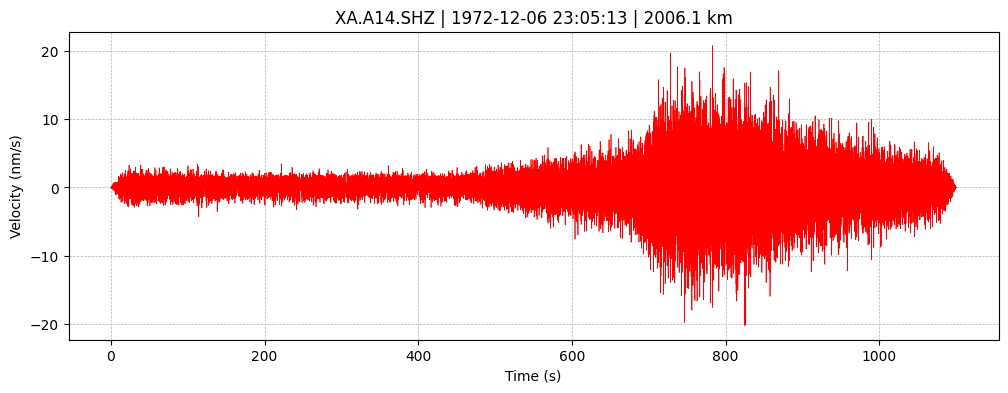

Sampling rate: 53.0 Hz


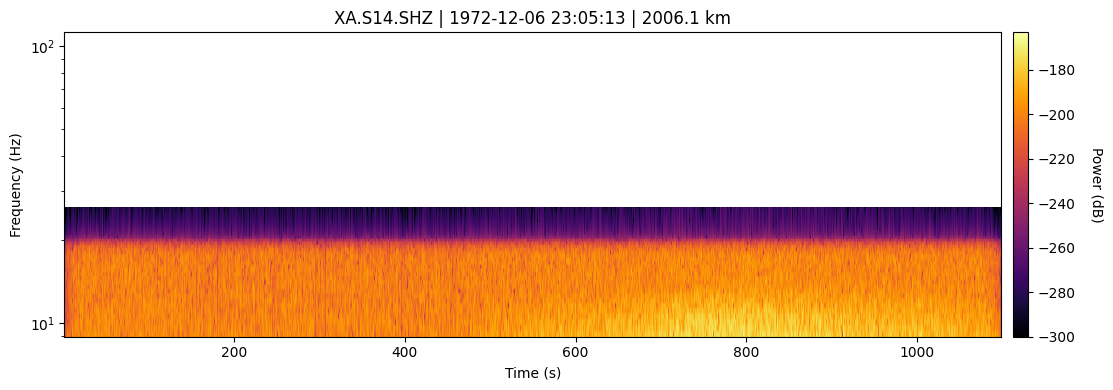

[OK] A14 1972-12-06T23:05:13.400000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A14/XA.A14.SHZ_19721206T230513


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


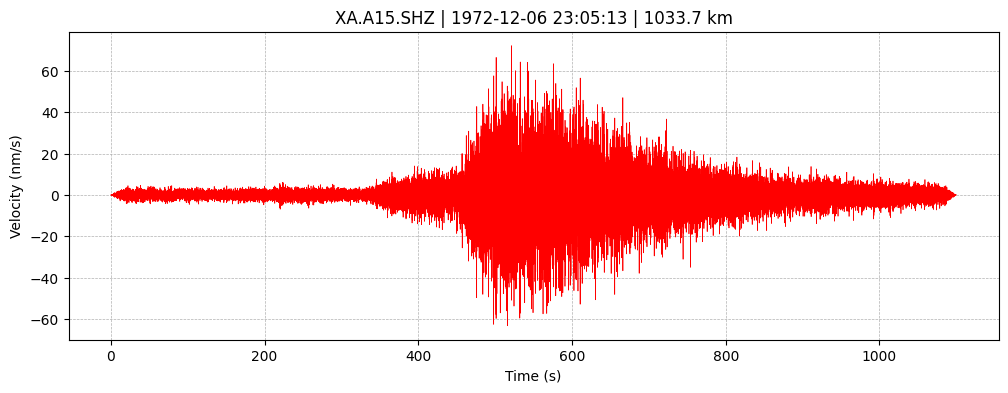

Sampling rate: 53.0 Hz


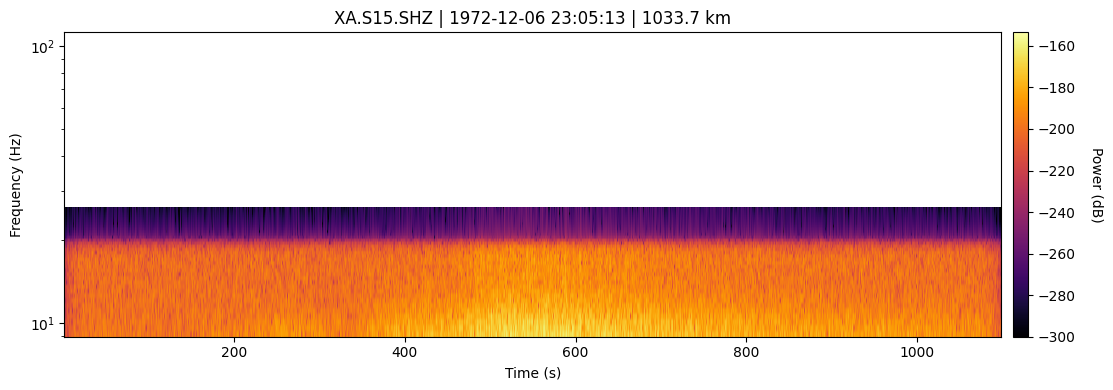

[OK] A15 1972-12-06T23:05:13.400000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A15/XA.A15.SHZ_19721206T230513


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


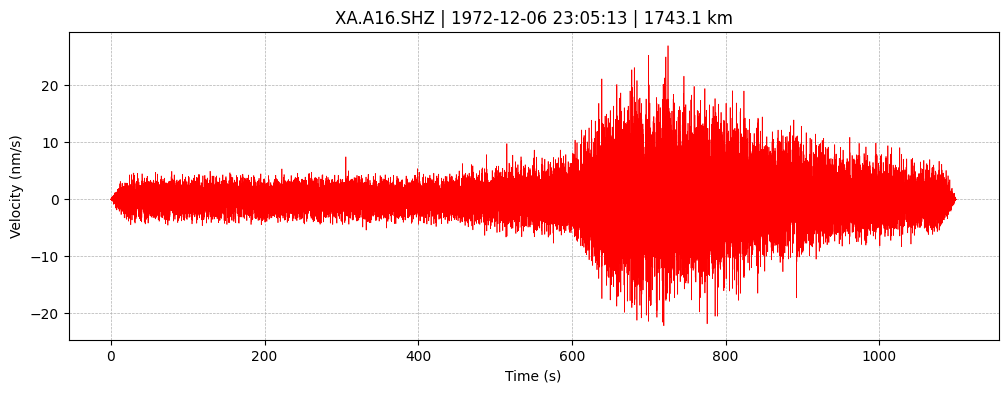

Sampling rate: 53.0 Hz


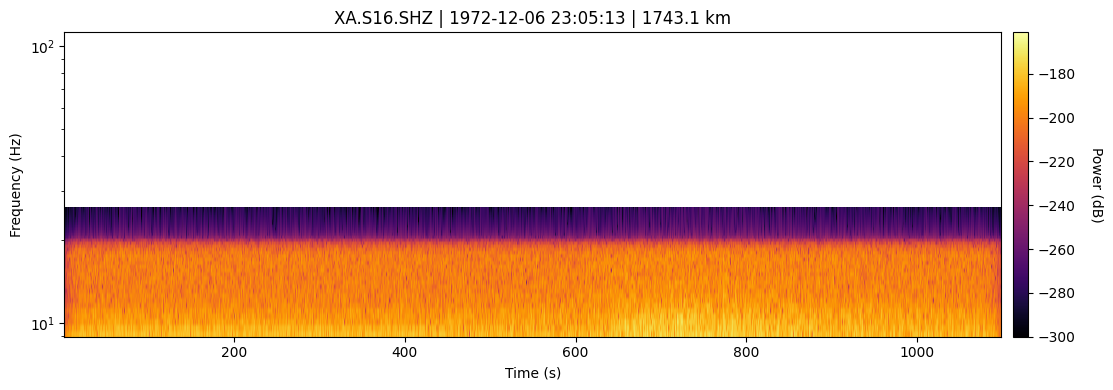

[OK] A16 1972-12-06T23:05:13.400000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A16/XA.A16.SHZ_19721206T230513


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


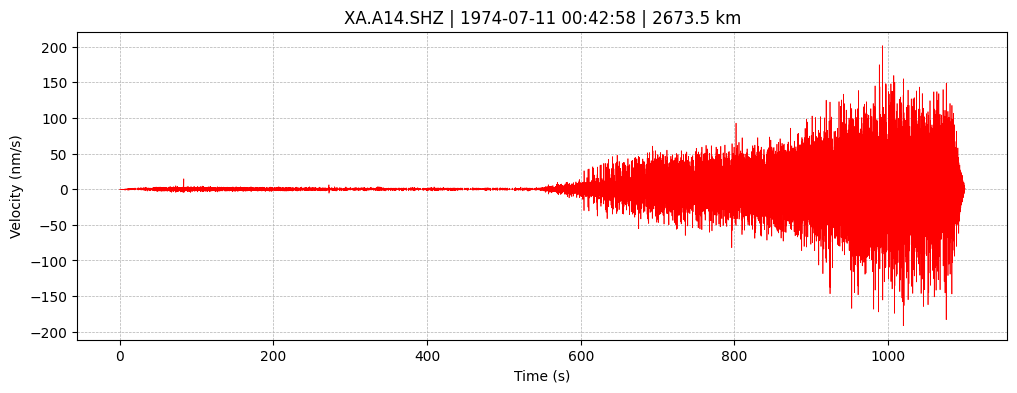

Sampling rate: 53.0 Hz


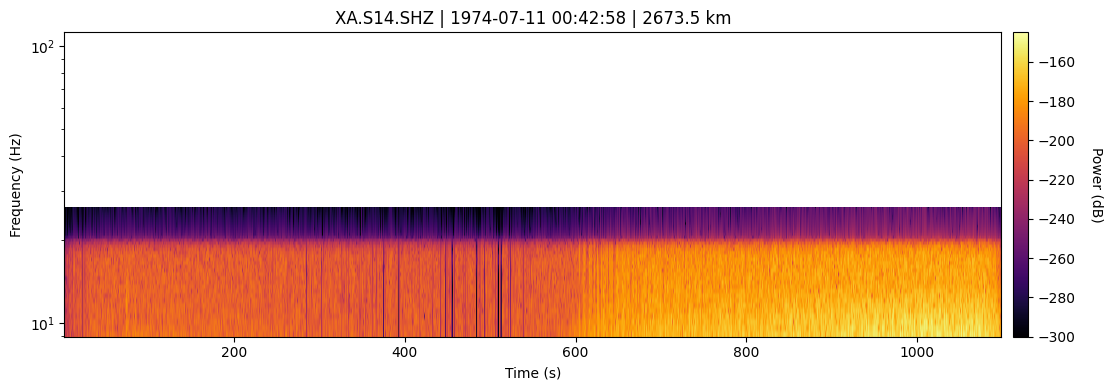

[OK] A14 1974-07-11T00:42:58.260000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A14/XA.A14.SHZ_19740711T004258


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


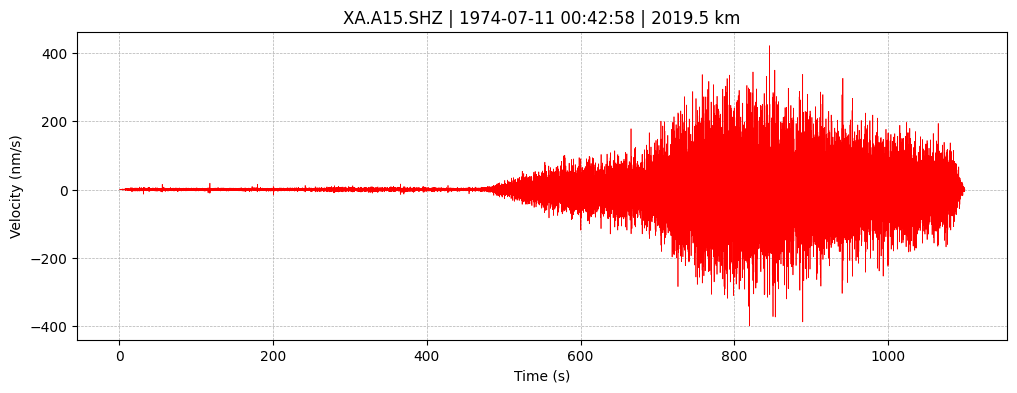

Sampling rate: 53.0 Hz


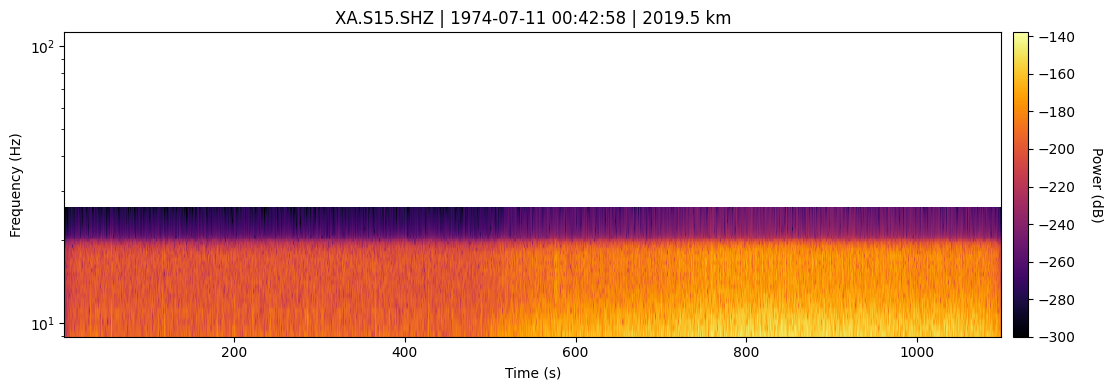

[OK] A15 1974-07-11T00:42:58.260000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A15/XA.A15.SHZ_19740711T004258


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


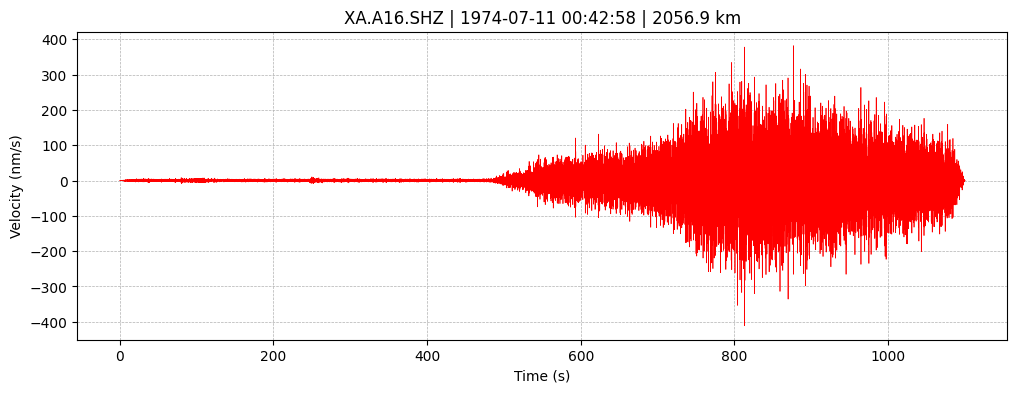

Sampling rate: 53.0 Hz


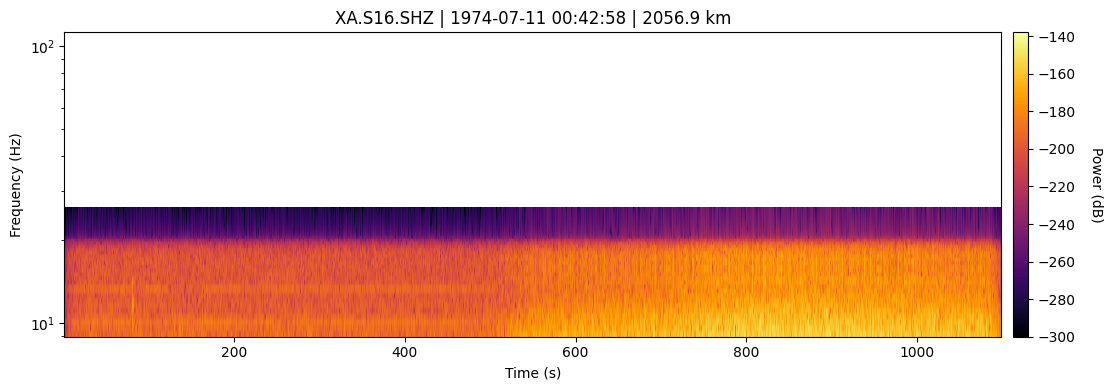

[OK] A16 1974-07-11T00:42:58.260000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A16/XA.A16.SHZ_19740711T004258


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


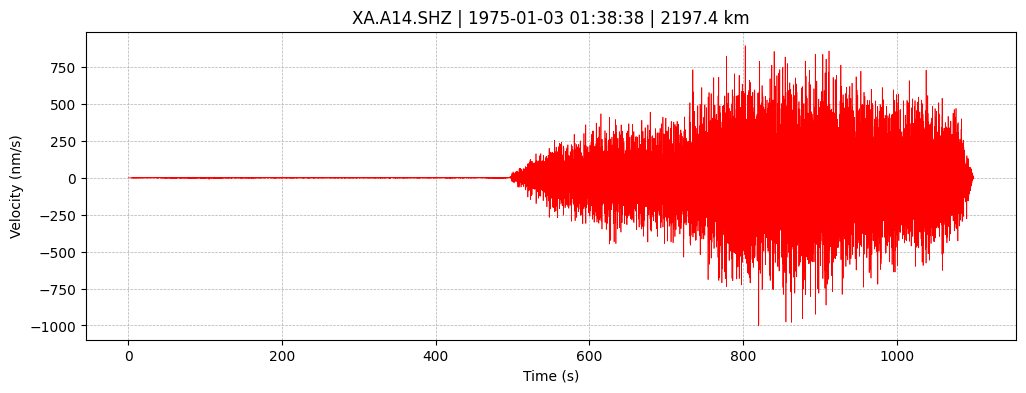

Sampling rate: 53.0 Hz


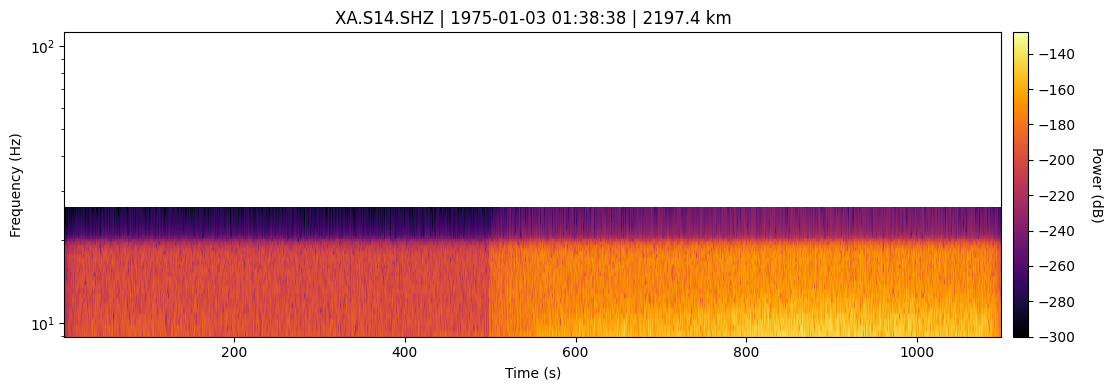

[OK] A14 1975-01-03T01:38:38.360000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A14/XA.A14.SHZ_19750103T013838


/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/src/heterogeneities/processing.py:31: FutureWarning: The 'downcast' keyword in Series.interpolate is deprecated and will be removed in a future version. Call result.infer_objects(copy=False) on the result instead.
  s.interpolate(


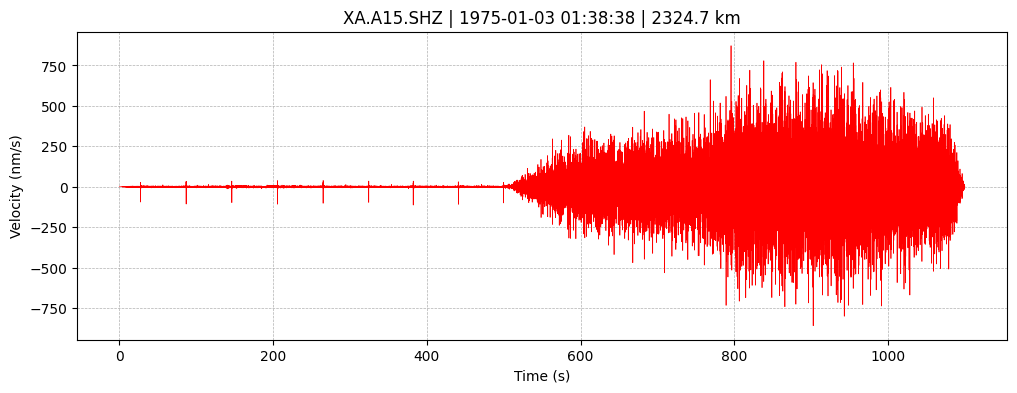

Sampling rate: 53.0 Hz


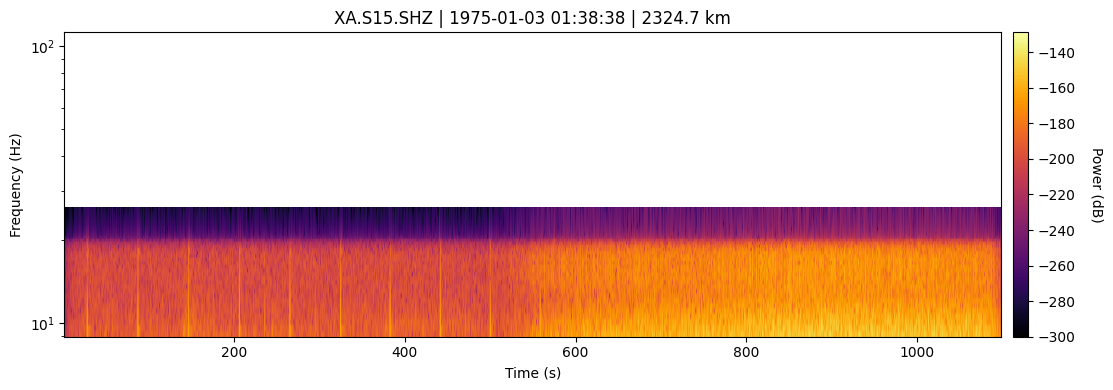

[OK] A15 1975-01-03T01:38:38.360000Z → /Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH/A15/XA.A15.SHZ_19750103T013838


KeyboardInterrupt: 

In [1]:
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, time as dtime
from obspy import UTCDateTime
import pandas as pd
from heterogeneities.io import view_apollo, plot_spectrogram_title, get_Apollo
from heterogeneities.processing import linear_interpolation, preprocess_trace, compute_spectrogram

# ✅ Correct dict
STATION_TO_APOLLO = {"S14": "A14", "S15": "A15", "S16": "A16"}
import re

def _row_stations(row, known_stations):
    """
    Return a list of station codes to process for this row, taken from the CSV.
    Accepts 'Station' or 'Stations' (case-insensitive) and supports values like:
      'S15', 'S14, S16', 'S14 S15', 'S14/S15', 'S14;S16'
    Only returns stations that exist in `known_stations`.
    """
    # find a 'station' field in the namedtuple (case-insensitive)
    station_attr = next((f for f in getattr(row, "_fields", []) if f.lower() in {"station", "stations"}), None)
    if not station_attr:
        return []

    raw = getattr(row, station_attr)
    if raw is None or (isinstance(raw, float) and pd.isna(raw)):
        return []

    tokens = [t for t in re.split(r"[,\s/;]+", str(raw).strip()) if t]
    # keep only stations we know about (e.g., S14, S15, S16)
    return [s for s in tokens if s in known_stations]


def _safe_hypo_distance(row, station):
    """
    Pick the correct hypo distance column for this station (hypo_dist_A14_km ...),
    otherwise fall back to the generic 'hypo_distance_km' (from the new CSV).
    """
    apollo = STATION_TO_APOLLO.get(station)
    if apollo:
        col = f"hypo_dist_{apollo}_km"
        if hasattr(row, col):
            val = getattr(row, col)
            if pd.notna(val):
                return float(val)
    # Fallback for the "Hypocentral distance (km)" CSV
    if hasattr(row, "hypo_distance_km") and pd.notna(row.hypo_distance_km):
        return float(row.hypo_distance_km)
    return None

def _event_folder_name(tr, apollo_code):
    """Folder name: XA.A*.SHZ_YYYYMMDDThhmmss"""
    t0 = tr.stats.starttime
    timestamp = t0.strftime("%Y%m%dT%H%M%S")
    return f"XA.{apollo_code}.SHZ_{timestamp}"

# ---------- Helpers to normalize the new CSV ----------

def _parse_distance_km(value):
    """
    Accept strings like:
      '1,545 ± 212', ' 1 545±212 ', '> 1,234', '1545', '1 545', '"1,545 ± 212"'
    Returns float or NaN.
    Strategy: cut at '±', strip '>', remove spaces and thousands separators, then float.
    """
    if pd.isna(value):
        return np.nan
    s = str(value)
    # take part before ± (or +/-)
    s = re.split(r"±|\+/-", s)[0]
    # remove quotes, spaces, thin spaces, and '>'
    s = s.replace('"', '').replace("’", "").replace(">", "")
    s = s.replace("\u2009", "").replace("\u202f", "").replace("\xa0", "").replace(" ", "")
    # if it's like 1,545 treat comma as thousands: drop commas
    # (if both comma and dot exist, still dropping commas is harmless)
    s = s.replace(",", "")
    # final clean
    s = s.strip()
    try:
        return float(s)
    except Exception:
        return np.nan

def _build_starttime_from_year_doy_time(year, doy, hhmmss):
    """
    Convert Year + DOY + 'Start time (UTC)' -> ISO string (UTC).
    """
    if pd.isna(year) or pd.isna(doy) or pd.isna(hhmmss):
        return np.nan
    try:
        year = int(year)
        doy = int(doy)
        # day 1 -> Jan 1
        dt0 = datetime(year, 1, 1) + timedelta(days=doy - 1)
        # parse HH:MM:SS
        parts = str(hhmmss).strip().split(":")
        h, m, s = (int(parts[0]), int(parts[1]), int(parts[2])) if len(parts) == 3 else (0, 0, 0)
        dt = datetime.combine(dt0.date(), dtime(h, m, s))
        # return ISO string; UTCDateTime can consume this
        return dt.strftime("%Y-%m-%dT%H:%M:%S")
    except Exception:
        return np.nan

def read_lognonne_table(filepath):
    """
    Read either:
      (a) your original CSV with 'starttime' and per-station hypo columns, or
      (b) the new CSV with 'Year', 'DOY', 'Start time (UTC)', and 'Hypocentral distance (km)'.
    Produces:
      - a 'starttime' column (ISO string) if missing
      - a 'hypo_distance_km' numeric column when the new distance column exists
    """
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Ensure a 'starttime' column exists
    if "starttime" not in df.columns:
        year_col = next((c for c in df.columns if c.strip().lower() == "year"), None)
        doy_col = next((c for c in df.columns if c.strip().lower() in {"doy", "day of year"}), None)
        utc_col = next((c for c in df.columns if c.strip().lower() in {"start time (utc)", "start time", "time (utc)"}), None)
        if year_col and doy_col and utc_col:
            df["starttime"] = df.apply(
                lambda r: _build_starttime_from_year_doy_time(r[year_col], r[doy_col], r[utc_col]),
                axis=1,
            )
        else:
            print("[WARN] Could not synthesize 'starttime' — expected Year/DOY/Start time (UTC).")

    # Normalize the "Hypocentral distance (km)" to a numeric column
    hypo_col = next(
        (c for c in df.columns if c.strip().lower() in {"hypocentral distance (km)", "hypocentral distance", "hypo distance (km)"}),
        None,
    )
    if hypo_col:
        df["hypo_distance_km"] = df[hypo_col].apply(_parse_distance_km)

    return df

# ---------- rest of your code (unchanged) ----------

def batch_make_plots(
    file_path,
    out_root="plots",
    stations=("S14", "S15", "S16"),
    network="XA",
    channel="SHZ",
    location="*",
    duration_sec=1300,
    spectrogram_kwargs=None,
):
    """
    For each row in the CSV, fetch seismograms for the requested stations and
    save a seismogram + spectrogram PDF in per-station folders:

      {out_root}/A14/XA.A14.SHZ_YYYYMMDDThhmmss/{seismogram,spectrogram}.pdf
    """
    spectrogram_kwargs = spectrogram_kwargs or {}
    out_root = Path(out_root)
    out_root.mkdir(parents=True, exist_ok=True)
    
    df = read_lognonne_table(file_path)
    if df is None or len(df) == 0:
        print("[ABORT] No rows to process.")
        return
    for row in df.itertuples():
        try:
            start = UTCDateTime(getattr(row, "starttime"))-200
            end = start + duration_sec
        except Exception as e:
            print(f"[SKIP] Row {getattr(row, 'Index', '?')}: invalid starttime ({e})")
            continue

        # 👇 Use ONLY the station(s) listed in this row, if provided
        row_station_list = _row_stations(row, known_stations={"S14", "S15", "S16"})
        stations_to_process = row_station_list if row_station_list else list(stations)

        for station in stations_to_process:
            apollo_code = STATION_TO_APOLLO.get(station)
            if not apollo_code:
                print(f"[SKIP] Row {getattr(row, 'Index', '?')}: unknown station '{station}'")
                continue

            try:
                st = get_Apollo(
                    starttime=start,
                    endtime=end,
                    station=station,
                    channel=channel,
                    units="VEL",
                    year=None,
                    month=None)

                if not st or len(st) == 0:
                    print(f"[SKIP] {station} {start}: no data returned")
                    continue

                tr = st.copy()
                trp = preprocess_trace(tr)
                #trp.filter("bandpass", freqmin=0.01, freqmax=15, corners=4, zerophase=True)

                station_dir = out_root / apollo_code / _event_folder_name(trp, apollo_code)
                station_dir.mkdir(parents=True, exist_ok=True)

                # ---------- Seismogram ----------
                times = np.arange(len(trp.data)) * trp.stats.delta
                fig, ax = plt.subplots(figsize=(12, 4))
                ax.plot(times, trp.data * 1e9, linewidth=0.5, color="red")
                ax.set_xlabel("Time (s)")
                ax.set_ylabel("Velocity (nm/s)")

                hypo_dist = _safe_hypo_distance(row, station)
                title = (
                    f"{trp.stats.network}.{apollo_code}.{trp.stats.channel} | "
                    f"{trp.stats.starttime.strftime('%Y-%m-%d %H:%M:%S')}"
                )
                if hypo_dist is not None and not np.isnan(hypo_dist):
                    title += f" | {hypo_dist:.1f} km"
                ax.set_title(title)
                ax.grid(True, linestyle="--", linewidth=0.5)

                seismo_path = station_dir / "seismogram.pdf"
                #fig.savefig(seismo_path, dpi=300, bbox_inches="tight")
                #plt.close()
                plt.show()

                # ---------- Spectrogram ----------
                dB, extent, freqs, stimes = compute_spectrogram(
                    trp,
                    window_sec=spectrogram_kwargs.get("window_sec", 0.8),
                    db_limits=spectrogram_kwargs.get("db_limits", None),
                )

                ax = plot_spectrogram_title(
                    dB,
                    extent,
                    trp,
                    vmin=spectrogram_kwargs.get("vmin", -190),
                    vmax=spectrogram_kwargs.get("vmax", -150),
                    show=False,
                    hypo_dist=hypo_dist,
                )
                spec_path = station_dir / "spectrogram.pdf"
                #plt.savefig(spec_path, dpi=300, bbox_inches="tight")
                #plt.close()
                plt.show()
                print(f"[OK] {apollo_code} {start} → {station_dir}")

            except Exception as e:
                print(f"[ERROR] {station} {start}: {e}")
                continue

file_path = "/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/data/raw/lognonne2003_table3_partial_with_dist_with_dist.csv"

batch_make_plots(
        file_path=file_path,
        out_root="/Users/ramonmargarit/Phd/Projects/Heterogeneities_Mantle/Heterogeneities-project/results/Onodera_new_SH",
        stations=("S14", "S15", "S16"),   # choose one or more
        duration_sec=1100,
        spectrogram_kwargs={"window_sec": 2, "vmin": None, "vmax": None}
    )